In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
from __future__ import division

import numpy as np
import glob, os, json
import matplotlib.pyplot as plt
import scipy.linalg as sl

import libstempo as libs
import libstempo.plot as libsplt

import enterprise
from enterprise.pulsar import Pulsar
from enterprise.signals import parameter
from enterprise.signals import white_signals
from enterprise.signals import utils
from enterprise.signals import gp_signals
from enterprise.signals import signal_base

import corner
from PTMCMCSampler.PTMCMCSampler import PTSampler as ptmcmc

In [3]:
topdir = os.getcwd()
#Where the original data is
datadir = topdir + '/mdc2/group1/dataset_1b'
#Where the json noise file is
noisefile = topdir + '/mdc2/group1/challenge1_psr_noise.json'
#Where the refit par files are
pardir = topdir + '/dataset_1b/dataset_1b_correctedpars/'
#Where the chains should be saved to
#NEED TO CHANGE OUTDIR FILE ON DIFFERENT RUNS (ie open1 -> open2)
chaindir = topdir + '/dataset_1b/chains/'
#Where we save figures n stuff
figdir = topdir + '/dataset_1b/Cornerplts/'
#Where we save new json file
noisedir = topdir + '/dataset_1b/'


parfiles = sorted(glob.glob(datadir + '/*.par'))
timfiles = sorted(glob.glob(datadir + '/*.tim'))

parfile_J0030 = datadir + '/J0030+0451.par'
timfile_J0030 = datadir + '/J0030+0451.tim'

In [9]:
def Refit_pars(origdir,newdir):
    orig_parfiles = sorted(glob.glob(origdir + '/*.par'))
    orig_timfiles = sorted(glob.glob(origdir + '/*.tim'))
    #Load all of the Pulsars into libstempo
    orig_libs_psrs = []
    for p, t in zip(orig_parfiles, orig_timfiles):
        orig_libs_psr = libs.tempopulsar(p, t)
        orig_libs_psrs.append(orig_libs_psr)

    #Fit the par files again
    #Save them to new directory (Overwrites ones currently used in savedir)
    #NOT WORKING ANYMORE
    if os.path.exists(newdir) == False:
        os.mkdir(newdir)
    for orig_libs_psr in orig_libs_psrs:
        orig_libs_psr['DM'].fit = False
        orig_libs_psr['DM1'].fit = False
        orig_libs_psr['DM2'].fit = False
        orig_libs_psr.fit(iters=10)
        orig_libs_psr.savepar(newdir + orig_libs_psr.name + '.par')
        orig_libs_psr.savetim(newdir + orig_libs_psr.name + '.tim')

In [13]:
def get_noise_from_pal2(noisefile):
    psrname = noisefile.split('/')[-1].split('_noise.txt')[0]
    fin = open(noisefile, 'r')
    lines = fin.readlines()
    params = {}
    for line in lines:
        ln = line.split()
        if 'efac' in line:
            par = 'efac'
            flag = ln[0].split('efac-')[-1]
        elif 'equad' in line:
            par = 'log10_equad'
            flag = ln[0].split('equad-')[-1]
        elif 'jitter_q' in line:
            par = 'log10_ecorr'
            flag = ln[0].split('jitter_q-')[-1]
        elif 'RN-Amplitude' in line:
            par = 'red_noise_log10_A'
            flag = ''
        elif 'RN-spectral-index' in line:
            par = 'red_noise_gamma'
            flag = ''
        else:
            break
        if flag:
            name = [psrname, flag, par]
        else:
            name = [psrname, par]
        pname = '_'.join(name)
        params.update({pname: float(ln[1])})
    return params

In [5]:
#Load Pulsar into enterprise
psr_J0030 = Pulsar(parfile_J0030,timfile_J0030)
#Load Pulsar into libstempo
libs_psr_J0030 = libs.tempopulsar(parfile = parfile_J0030,timfile = timfile_J0030)

In [ ]:
#Check new residuals
Refit_pars(datadir,pardir)

In [10]:
fit_parfiles = sorted(glob.glob(pardir + '/*.par'))

fit_libs_psrs = []
for p, t in zip(fit_parfiles, orig_timfiles):
    print(p)
    fit_libs_psr = libs.tempopulsar(p, t)
    fit_libs_psrs.append(fit_libs_psr)

LinAlgError: 17-th leading minor of the array is not positive definite

In [1]:
npsr = 0
fit_libs_psrs.pltres(npsr)

NameError: name 'fit_libs_psrs' is not defined

In [5]:
#Load all Pulsars into enterprise
psrs = []
for p, t in zip(parfiles, timfiles):
    psr = Pulsar(p, t)
    psrs.append(psr)
print(len(psrs))

33


In [1]:
# find the maximum time span to set GW frequency sampling
tmin = [p.toas.min() for p in psrs]
tmax = [p.toas.max() for p in psrs]
Tspan = np.max(tmax) - np.min(tmin)

NameError: name 'psrs' is not defined

In [9]:
############ TESTING ON ONE PULSAR ###################

##### parameters and priors #####

# Uniform prior on EFAC and EQUAD
efac = parameter.Uniform(0.1, 5.0)
log10_equad = parameter.Uniform(-10.0,-4.0)

# red noise parameters
# Uniform in log10 Amplitude and in spectral index
log10_A = parameter.Uniform(-18,-12)
gamma = parameter.Uniform(0,7)

##### Set up signals #####

# white noise
ef = white_signals.MeasurementNoise(efac=efac)
eq = white_signals.EquadNoise(log10_equad = log10_equad)

# red noise (powerlaw with 30 frequencies)
pl = utils.powerlaw(log10_A=log10_A, gamma=gamma)
rn = gp_signals.FourierBasisGP(spectrum=pl, components=30)

# timing model
tm = gp_signals.TimingModel()

# full model is sum of components
model = ef + rn + tm + eq

# initialize PTA for example pulsar
pta_test = signal_base.PTA([model(psr_J0030)])

In [10]:
############ TESTING ON ONE PULSAR ###################

#Pick random initial sampling
xs_test = {par.name: par.sample() for par in pta_test.params}
    
# Now we figure out which indices the red noise parameters have
rn_idx1 = pta_test.param_names.index(psr_J0030.name + '_red_noise_log10_A')
rn_idx2 = pta_test.param_names.index(psr_J0030.name + '_red_noise_gamma')

# dimension of parameter space
ndim = len(xs_test)

# initial jump covariance matrix
cov = np.diag(np.ones(ndim) * 0.01**2)

# set up jump groups by red noise groups
ndim = len(xs_test)
groups  = [range(0, ndim)]
groups.extend([[rn_idx1,rn_idx2]])

# intialize sampler
sampler = ptmcmc(ndim, pta_test.get_lnlikelihood, pta_test.get_lnprior, cov, groups=groups)
    
# sampler for N steps
N = 100000
x0 = np.hstack(p.sample() for p in pta_test.params)
sampler.sample(x0, N, SCAMweight=30, AMweight=15, DEweight=50)

Finished 2.00 percent in 2.216121 s Acceptance rate = 0.889

/home/andrew/anaconda3/envs/enterprise/lib/python3.6/site-packages/enterprise/signals/parameter.py:66: RuntimeWarning: divide by zero encountered in log
  logpdf = np.log(self.prior(value, **kwargs))


Finished 10.00 percent in 10.688683 s Acceptance rate = 0.5349Adding DE jump with weight 50
Finished 99.00 percent in 95.435680 s Acceptance rate = 0.466172
Run Complete


In [11]:
#Example for making dictionary of dictionary for json file
psr_dict = {}
for psr in psrs:
    psr_dict[psr.name] = {}
    for i,j in zip(xs_test,range(len(xs_test))):
        psr_dict[psr.name][i] = j

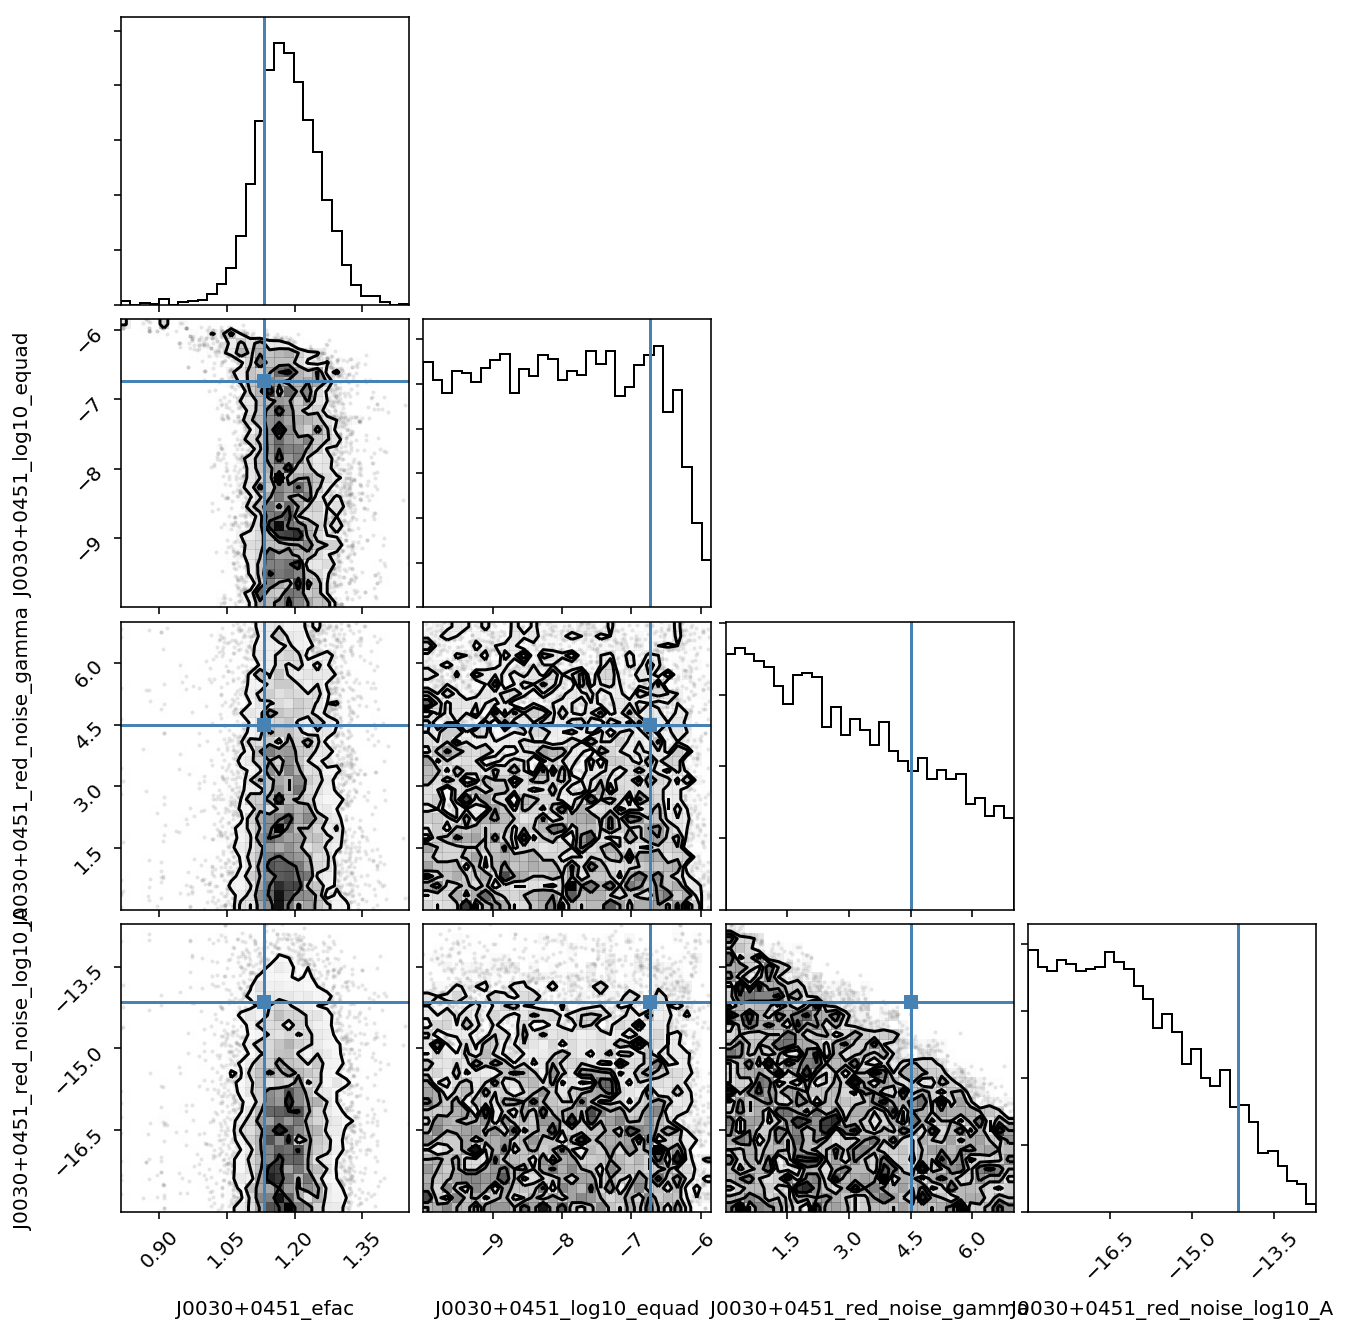

In [24]:
#Get true noise values for pulsar to plot in corner plot (truth values)
with open(noisefile, 'r') as nf:
    inputvals = json.load(nf)
    nf.close()
#Unpacking dictionaries in json file to get at noise values
noise_vals = inputvals[psr_J0030.name]
truths = [noise_vals["efac"], noise_vals["equad"], noise_vals["rn_spec_ind"], noise_vals["rn_log10_A"]]

chain = np.loadtxt(os.getcwd() + '/chains/chain_1.txt')
pars = sorted(xs_test.keys())
burn = int(0.25 * chain.shape[0])
corner.corner(chain[burn:,:-4], 30, truths=truths, labels=pars);

In [57]:
for psr in psrs:
    outdir = chaindir + psr.name + '/'
    if not os.path.exists(outdir):
        os.mkdir(outdir)
        
    # initialize PTA
    pta = signal_base.PTA([model(psr)])

    #Pick random initial sampling
    xs = {par.name: par.sample() for par in pta.params}
    
    # Now we figure out which indices the red noise parameters have
    rn_idx1 = pta.param_names.index(psr.name + '_log10_equad')
    rn_idx2 = pta.param_names.index(psr.name + '_gamma')

    # dimension of parameter space
    ndim = len(xs)

    # initial jump covariance matrix
    cov = np.diag(np.ones(ndim) * 0.01**2)

    # set up jump groups by red noise groups
    ndim = len(xs)
    groups  = [range(0, ndim)]
    groups.extend([[rn_idx1,rn_idx2]])

    # intialize sampler
    sampler = ptmcmc(ndim, pta.get_lnlikelihood, pta.get_lnprior, cov, groups=groups, outDir=outdir, resume = False)
    
    # sampler for N steps
    N = 100000
    x0 = np.hstack(p.sample() for p in pta.params)
    sampler.sample(x0, N, SCAMweight=30, AMweight=15, DEweight=50)
    

TypeError: 'list' object is not callable

In [12]:
chain = np.loadtxt(chaindir + '/chain_1.txt')
pars = sorted(xs.keys())
burn = int(0.25 * chain.shape[0])

truths = [1.0, 4.33, np.log10(5e-14)]
corner.corner(chain[burn:,:-4], 30, labels=pars);

OSError: /home/andrew/Documents/Research/NANOGrav/MDC2/dataset_1b/chains//chain_1.txt not found.